In [59]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, metrics

In [60]:
from scipy.ndimage import convolve
from scipy.signal import convolve2d

class Connect4Game(object):
  def __init__(self):
    self.board = np.zeros((6, 7))
    self.tops = np.zeros(7)
    self.moves_played = 0
    self.pieces = {1: "|0|",
                   0: "|·|",
                   -1:"|O|"}
  def render(self):
    for row in reversed(range(6)):
      print(''.join([self.pieces[i] for i in self.board[row].astype(np.int)]))
  def reset(self):
    self.board *= 0
    self.tops *= 0
    self.moves_played = 0
  def play(self, col, color):
    self.board[int(self.tops[col])][col] = color
    self.tops[col] += 1
    self.moves_played += 1
  def result(self):
    """ Returns 0 if it's a tie; returns None if the game is not over; returns -1 if player -1 wins, and 1 if player 1 wins."""
    if self.moves_played == 42: return 0
    kernel_row = [[1, 1, 1, 1]]
    kernel_col = [[1],
                  [1],
                  [1],
                  [1]]
    kernel_dia = [[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]]
    kernel_dia2 = [[0, 0, 0, 1],
                  [0, 0, 1, 0],
                  [0, 1, 0, 0],
                  [1, 0, 0, 0]]
    for kernel in [np.array(kernel_row), np.array(kernel_col), np.array(kernel_dia), np.array(kernel_dia2)]:
      check = convolve2d(self.board, kernel, mode='same', boundary='fill', fillvalue=0)
      #print(check)
      if (check == 4).any(): return 1
      check2 = convolve2d(self.board, -kernel, mode='same', boundary='fill', fillvalue=0)
      if (check2 == 4).any(): return -1
    return None 


In [30]:
def human_play():
  game = Connect4Game()
  turn = 1
  while game.result() == None:
    game.render()
    game.play(int(input()), turn); turn *= -1
  print("Result: ", game.result())

In [39]:
import tqdm
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as kb

def create_P_network(NUM_CONV_LAYERS = 5, describe = True):
    in_ = layers.Input((6, 7))
    X = layers.Reshape((6, 7, 1))(in_)
    for i in range(NUM_CONV_LAYERS-1):
        X_skip = layers.Conv2D(32, (4,4), activation = 'relu', padding = "same")(X)
        X_skip = layers.BatchNormalization()(X_skip)
        X_skip = layers.Conv2D(32, (2,2), activation = 'relu', padding = "same")(X_skip)
        X_skip = layers.BatchNormalization()(X_skip)
        X = layers.BatchNormalization()(X)
        X = layers.Add()([X_skip, X])
    X = layers.Conv2D(32, (3,3), activation = 'relu')(X)
    X = layers.BatchNormalization()(X)
    #X = layers.GlobalAveragePooling2D()(X)
    X = layers.Flatten()(X)
    #X = layers.Dense(256, activation = 'relu')(X)
    X = layers.Dense(7, activation = 'softmax')(X)
    model = models.Model(in_, X)
    if describe: 
        model.summary()
    return model

class TrainBuffer(object):
    def __init__(self, max_queue = 50000, clean_extra = 10000):
        self.X1 = []; self.X2 = []
        self.y = []; self.max_queue = max_queue
        self.clean_extra = clean_extra
    def push(self, X1, X2, y):
        self.X1.extend(X1)
        self.X2.extend(X2)
        self.y.extend(y)
        #if len(self.y) > self.max_queue: self.y = self.y[len(self.y) - self.max_queue:]
        if len(self.X1) > self.max_queue + self.clean_extra:
            idxs = np.random.choice(len(self.X1), size = self.max_queue, replace = False)
            tmp_X1 = [self.X1[idxs[i]] for i in range(self.max_queue)]
            tmp_X2 = [self.X2[idxs[i]] for i in range(self.max_queue)]
            tmp_y = [self.y[idxs[i]] for i in range(self.max_queue)]
            self.X1 = tmp_X1
            self.X2 = tmp_X2
            self.y = tmp_y
            


class REINFORCELearner(object):
    def __init__(self):
        self.game = Connect4Game()
        self.model = create_P_network()
        self.teacher = create_P_network()
        self.buffer = TrainBuffer()
        self.train_every = 500
        self.gamma = 0.95
        self.model.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(1e-4), metrics = ['acc', 'mse'])

    def norm_probs(self, probs):
        probs *= (self.game.tops != 6)
        probs *= (1 / np.sum(probs))
        return probs

    def push_to_buffer(self, result, p1_states, p1_actions, pneg1_states, pneg1_actions):
        if result == 1:
            labels = []; reward = 1
            for i in reversed(p1_actions):
                label = np.zeros(7); label[i] = reward; labels.append(label); reward *= self.gamma
            self.buffer.push(p1_states, p1_actions, reversed(labels))
        if result == -1:
            labels = []; reward = 1
            for i in reversed(pneg1_actions):
                label = np.zeros(7); label[i] = reward; labels.append(label); reward *= self.gamma
            self.buffer.push(pneg1_states, pneg1_actions, reversed(labels))
        
    def run_game(self):
        states_p1, actions_p1, states_pneg1, actions_pneg1 = [], [], [], []
        turn = 1
        while (self.game.result() == None):
            state = self.game.board * turn
            P = self.teacher(state[np.newaxis,:,:])
            preds = P.numpy()[0]
            probs = self.norm_probs(preds)

            action = np.random.choice(range(0, 7), p = probs)
            self.game.play(action, turn)
            if turn == 1: 
                states_p1.append(state)
                actions_p1.append(action)
            else: 
                states_pneg1.append(state)
                actions_pneg1.append(action)
            turn *= -1
            
        self.push_to_buffer(self.game.result(), states_p1, actions_p1, states_pneg1, actions_pneg1)
        self.game.reset()

    def train(self, epochs = 1):
        for j in tqdm.trange(epochs):
            for i in range(self.train_every):
                self.run_game()
            self.model.fit(x = np.array(self.buffer.X1), y = np.array(self.buffer.y), batch_size = 512)

In [32]:
# Evaluate
import random

class Ladder(object):
    def __init__(self):
        self.game = Connect4Game()
    def play_match(self, player_1, player_neg1, render = False):
        turn = 1
        self.game.reset()
        while (self.game.result() == None):
            if render: self.game.render()

            state = self.game.board * turn
            if turn == 1:
                action = player_1.make_move(state, self.game.tops)
            if turn == -1:
                action = player_neg1.make_move(state, self.game.tops)
            self.game.play(action, turn)
            
            turn *= -1
            
        result = self.game.result()
        self.game.reset()
        return result
    
    def play_tournament(self, players, NUM_MATCHES = 1000, K = 16, onesd = 400):
        MMR = {}
        for player in players:
            MMR[player.name] = 1000
        for match in tqdm.trange(NUM_MATCHES):
            p1, p_neg1 = random.sample(players, 2)
            result = self.play_match(p1, p_neg1)
            
            SA = (result + 1) / 2 # A scores 1 point if win, 0 points if loss.
            SB = (-result + 1) / 2 # B scores 1 point if win, -1 points if loss.
            # Both score 0.5 points if tie.
            EA = 1 / (1 + 10**((MMR[p_neg1.name] - MMR[p1.name]) / onesd))
            EB = 1 / (1 + 10**((MMR[p1.name] - MMR[p_neg1.name]) / onesd))
            
            MMR[p1.name] = MMR[p1.name] + K * (SA - EA)
            MMR[p_neg1.name] = MMR[p_neg1.name] + K * (SB - EB)
        new_MMR = {}
        for key in MMR:
            new_MMR[key] = 1000 + MMR[key] - MMR["Random"]
        return new_MMR

In [41]:
# All a class needs to be a valid player is the method make_move(self, state, tops) and the attribute name.

class RLPlayer(object):
    def __init__(self, model, name):
        self.model = model; self.name = name
        self.DETERMINISTIC = False
    def norm_probs(self, probs, tops):
        probs *= (tops != 6)
        probs *= (1 / np.sum(probs))
        return probs
    def make_move(self, state, tops): # Tops is the top of each column in game, used for not making invalid moves
        P = self.model(state[np.newaxis,:,:])
        preds = P.numpy()[0]
        probs = self.norm_probs(preds, tops)
        if not self.DETERMINISTIC: action = np.random.choice(range(0, 7), p = probs)
        else: action = np.argmax(probs)
        return action
    
class RandomPlayer(object):
    def __init__(self, name = "Random"):
        self.name = name
    def norm_probs(self, probs, tops):
        probs *= (tops != 6)
        probs *= (1 / np.sum(probs))
        return probs
    def make_move(self, state, tops):
        probs = np.ones(7) / 7
        probs = self.norm_probs(probs, tops)
        return np.random.choice(range(0, 7), p = probs)


In [34]:
agent = REINFORCELearner()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 7)]       0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 6, 7, 1)      0           ['input_3[0][0]']                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 6, 7, 32)     544         ['reshape_2[0][0]']              
                                                                                                  
 batch_normalization_17 (BatchN  (None, 6, 7, 32)    128         ['conv2d_12[0][0]']              
 ormalization)                                                                              

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6, 7)]       0           []                               
                                                                                                  
 reshape_3 (Reshape)            (None, 6, 7, 1)      0           ['input_4[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 6, 7, 32)     544         ['reshape_3[0][0]']              
                                                                                                  
 batch_normalization_30 (BatchN  (None, 6, 7, 32)    128         ['conv2d_21[0][0]']              
 ormalization)                                                                              

In [ ]:
R = RandomPlayer()
players = [R]

In [50]:
last_mmr = 0
for k in range(0,50):
    print("================Epoch "+str(k)+"==================")
    print("Games played:", k * 10 * agent.train_every)
    agent.train(epochs = 10)
    
    ladder = Ladder()
    P = RLPlayer(model = agent.model, name = "Epoch" + str(k))
    players.append(P)
    results = ladder.play_tournament(players, NUM_MATCHES = 500)
    print("================Ending Tournament Results=============")
    print(results)
    
    if (results["Epoch" + str(k)] > last_mmr):
        agent.model.save_weights(str(k) + "_v4.h5")
        agent.teacher.set_weights(agent.model.get_weights())
        last_mmr = results["Epoch" + str(k)]

================Epoch 0==================
Games played: 0


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

116/116 [==============================] - 22s 185ms/step - loss: 1.3792 - acc: 0.2680 - mse: 0.0723


 10%|████████▏                                                                         | 1/10 [03:02<27:23, 182.60s/it]

107/107 [==============================] - 19s 177ms/step - loss: 1.3759 - acc: 0.2710 - mse: 0.0721


 20%|████████████████▍                                                                 | 2/10 [06:01<24:01, 180.21s/it]

117/117 [==============================] - 21s 182ms/step - loss: 1.3759 - acc: 0.2716 - mse: 0.0721


 30%|████████████████████████▌                                                         | 3/10 [09:06<21:17, 182.44s/it]

108/108 [==============================] - 21s 190ms/step - loss: 1.3746 - acc: 0.2743 - mse: 0.0720


 40%|████████████████████████████████▊                                                 | 4/10 [12:17<18:36, 186.08s/it]

99/99 [==============================] - 21s 217ms/step - loss: 1.3755 - acc: 0.2776 - mse: 0.0720


 50%|█████████████████████████████████████████                                         | 5/10 [15:18<15:19, 183.94s/it]

110/110 [==============================] - 19s 175ms/step - loss: 1.3751 - acc: 0.2773 - mse: 0.0720


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:22<12:16, 184.20s/it]

100/100 [==============================] - 18s 175ms/step - loss: 1.3762 - acc: 0.2780 - mse: 0.0720


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:33<09:18, 186.24s/it]

111/111 [==============================] - 19s 170ms/step - loss: 1.3740 - acc: 0.2808 - mse: 0.0719


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:48<06:18, 189.20s/it]

102/102 [==============================] - 18s 175ms/step - loss: 1.3717 - acc: 0.2812 - mse: 0.0718


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:57<03:09, 189.07s/it]

113/113 [==============================] - 21s 188ms/step - loss: 1.3713 - acc: 0.2835 - mse: 0.0717


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:01<00:00,  4.12it/s]


================Ending Tournament Results=============
{'Random': 1000.0000000000001, 'Epoch0': 1018.7015788322375}
================Epoch 1==================
Games played: 5000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

103/103 [==============================] - 18s 179ms/step - loss: 1.3764 - acc: 0.2823 - mse: 0.0720


 10%|████████▏                                                                         | 1/10 [02:57<26:41, 177.96s/it]

114/114 [==============================] - 21s 188ms/step - loss: 1.3788 - acc: 0.2832 - mse: 0.0721


 20%|████████████████▍                                                                 | 2/10 [06:07<24:38, 184.87s/it]

105/105 [==============================] - 20s 191ms/step - loss: 1.3809 - acc: 0.2810 - mse: 0.0722


 30%|████████████████████████▌                                                         | 3/10 [09:24<22:10, 190.11s/it]

115/115 [==============================] - 20s 175ms/step - loss: 1.3825 - acc: 0.2829 - mse: 0.0723


 40%|████████████████████████████████▊                                                 | 4/10 [12:27<18:43, 187.32s/it]

106/106 [==============================] - 18s 174ms/step - loss: 1.3865 - acc: 0.2796 - mse: 0.0725


 50%|█████████████████████████████████████████                                         | 5/10 [15:23<15:16, 183.28s/it]

116/116 [==============================] - 21s 180ms/step - loss: 1.3892 - acc: 0.2786 - mse: 0.0727


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:21<12:06, 181.52s/it]

107/107 [==============================] - 20s 184ms/step - loss: 1.3915 - acc: 0.2788 - mse: 0.0728


 70%|███████████████████████████████████████████████████████▎                       | 7/10 [1:08:22<55:10, 1103.39s/it]

118/118 [==============================] - 22s 184ms/step - loss: 1.3936 - acc: 0.2772 - mse: 0.0729


 80%|████████████████████████████████████████████████████████████████                | 8/10 [1:11:45<27:13, 816.69s/it]

109/109 [==============================] - 20s 180ms/step - loss: 1.3952 - acc: 0.2748 - mse: 0.0730


 90%|████████████████████████████████████████████████████████████████████████        | 9/10 [1:15:02<10:23, 623.10s/it]

99/99 [==============================] - 18s 180ms/step - loss: 1.3957 - acc: 0.2768 - mse: 0.0730


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:19<00:00,  3.58it/s]


================Ending Tournament Results=============
{'Random': 1000.0, 'Epoch0': 977.3169941783465, 'Epoch1': 1024.7856185166704}
================Epoch 2==================
Games played: 10000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

109/109 [==============================] - 19s 179ms/step - loss: 1.4005 - acc: 0.2714 - mse: 0.0732


 10%|████████▏                                                                         | 1/10 [03:06<27:54, 186.08s/it]

100/100 [==============================] - 18s 179ms/step - loss: 1.4053 - acc: 0.2729 - mse: 0.0735


 20%|████████████████▍                                                                 | 2/10 [06:11<24:43, 185.43s/it]

110/110 [==============================] - 20s 179ms/step - loss: 1.4087 - acc: 0.2692 - mse: 0.0737


 30%|████████████████████████▌                                                         | 3/10 [09:13<21:29, 184.26s/it]

101/101 [==============================] - 18s 178ms/step - loss: 1.4124 - acc: 0.2661 - mse: 0.0739


 40%|████████████████████████████████▊                                                 | 4/10 [12:18<18:25, 184.31s/it]

111/111 [==============================] - 20s 180ms/step - loss: 1.4152 - acc: 0.2641 - mse: 0.0740


 50%|█████████████████████████████████████████                                         | 5/10 [15:24<15:24, 184.89s/it]

102/102 [==============================] - 18s 177ms/step - loss: 1.4180 - acc: 0.2635 - mse: 0.0741


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:22<12:10, 182.75s/it]

112/112 [==============================] - 20s 178ms/step - loss: 1.4207 - acc: 0.2605 - mse: 0.0743


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:30<09:12, 184.32s/it]

103/103 [==============================] - 18s 179ms/step - loss: 1.4212 - acc: 0.2616 - mse: 0.0743


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:35<06:08, 184.43s/it]

113/113 [==============================] - 22s 196ms/step - loss: 1.4265 - acc: 0.2566 - mse: 0.0746


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:48<03:07, 187.37s/it]

103/103 [==============================] - 19s 181ms/step - loss: 1.4274 - acc: 0.2596 - mse: 0.0746


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:16<00:00,  3.65it/s]


================Ending Tournament Results=============
{'Random': 1000.0, 'Epoch0': 1021.5090766801018, 'Epoch1': 953.5965790388932, 'Epoch2': 986.5094286559677}
================Epoch 3==================
Games played: 15000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

113/113 [==============================] - 20s 176ms/step - loss: 1.4291 - acc: 0.2570 - mse: 0.0747


 10%|████████▏                                                                         | 1/10 [03:03<27:32, 183.60s/it]

104/104 [==============================] - 19s 178ms/step - loss: 1.4302 - acc: 0.2583 - mse: 0.0748


 20%|████████████████▍                                                                 | 2/10 [06:05<24:19, 182.42s/it]

114/114 [==============================] - 20s 177ms/step - loss: 1.4317 - acc: 0.2569 - mse: 0.0749


 30%|████████████████████████▌                                                         | 3/10 [09:08<21:19, 182.81s/it]

105/105 [==============================] - 19s 182ms/step - loss: 1.4318 - acc: 0.2560 - mse: 0.0749


 40%|████████████████████████████████▊                                                 | 4/10 [12:15<18:26, 184.35s/it]

115/115 [==============================] - 21s 181ms/step - loss: 1.4335 - acc: 0.2548 - mse: 0.0750


 50%|█████████████████████████████████████████                                         | 5/10 [15:16<15:16, 183.37s/it]

105/105 [==============================] - 19s 178ms/step - loss: 1.4354 - acc: 0.2527 - mse: 0.0751


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:20<12:14, 183.58s/it]

115/115 [==============================] - 21s 182ms/step - loss: 1.4356 - acc: 0.2527 - mse: 0.0751


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:21<09:07, 182.66s/it]

106/106 [==============================] - 19s 181ms/step - loss: 1.4350 - acc: 0.2552 - mse: 0.0751


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:29<06:08, 184.19s/it]

116/116 [==============================] - 21s 180ms/step - loss: 1.4350 - acc: 0.2540 - mse: 0.0750


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:42<03:07, 187.02s/it]

107/107 [==============================] - 19s 180ms/step - loss: 1.4350 - acc: 0.2526 - mse: 0.0750


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:26<00:00,  3.42it/s]


================Ending Tournament Results=============
{'Random': 1000.0, 'Epoch0': 1184.527361089248, 'Epoch1': 1124.2974064751731, 'Epoch2': 1119.0351314066013, 'Epoch3': 1130.0352162673332}
================Epoch 4==================
Games played: 20000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

117/117 [==============================] - 21s 176ms/step - loss: 1.4377 - acc: 0.2511 - mse: 0.0751


 10%|████████▏                                                                         | 1/10 [03:01<27:12, 181.44s/it]

108/108 [==============================] - 19s 180ms/step - loss: 1.4407 - acc: 0.2506 - mse: 0.0753


 20%|████████████████▍                                                                 | 2/10 [06:04<24:19, 182.40s/it]

99/99 [==============================] - 18s 182ms/step - loss: 1.4444 - acc: 0.2461 - mse: 0.0754


 30%|████████████████████████▌                                                         | 3/10 [09:07<21:20, 182.89s/it]

109/109 [==============================] - 20s 181ms/step - loss: 1.4455 - acc: 0.2460 - mse: 0.0755


 40%|████████████████████████████████▊                                                 | 4/10 [12:09<18:14, 182.38s/it]

99/99 [==============================] - 18s 181ms/step - loss: 1.4462 - acc: 0.2487 - mse: 0.0756


 50%|█████████████████████████████████████████                                         | 5/10 [15:12<15:12, 182.48s/it]

109/109 [==============================] - 20s 180ms/step - loss: 1.4468 - acc: 0.2475 - mse: 0.0755


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:20<12:18, 184.56s/it]

100/100 [==============================] - 18s 181ms/step - loss: 1.4474 - acc: 0.2462 - mse: 0.0756


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:23<09:12, 184.03s/it]

110/110 [==============================] - 20s 181ms/step - loss: 1.4491 - acc: 0.2472 - mse: 0.0757


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:24<06:05, 182.94s/it]

100/100 [==============================] - 18s 181ms/step - loss: 1.4505 - acc: 0.2469 - mse: 0.0758


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:22<03:01, 181.50s/it]

110/110 [==============================] - 20s 178ms/step - loss: 1.4517 - acc: 0.2456 - mse: 0.0758


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:22<00:00,  3.52it/s]


================Ending Tournament Results=============
{'Random': 1000.0000000000001, 'Epoch0': 978.8236349580394, 'Epoch1': 980.309772381571, 'Epoch2': 990.3716818134136, 'Epoch3': 1055.6006408363828, 'Epoch4': 957.260091791196}
================Epoch 5==================
Games played: 25000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

101/101 [==============================] - 18s 179ms/step - loss: 1.4518 - acc: 0.2452 - mse: 0.0758


 10%|████████▏                                                                         | 1/10 [03:10<28:30, 190.06s/it]

111/111 [==============================] - 20s 180ms/step - loss: 1.4523 - acc: 0.2473 - mse: 0.0759


 20%|████████████████▍                                                                 | 2/10 [06:09<24:32, 184.04s/it]

102/102 [==============================] - 19s 183ms/step - loss: 1.4530 - acc: 0.2481 - mse: 0.0759


 30%|████████████████████████▌                                                         | 3/10 [09:14<21:28, 184.13s/it]

112/112 [==============================] - 20s 180ms/step - loss: 1.4526 - acc: 0.2471 - mse: 0.0758


 40%|████████████████████████████████▊                                                 | 4/10 [12:22<18:35, 185.89s/it]

103/103 [==============================] - 19s 182ms/step - loss: 1.4537 - acc: 0.2470 - mse: 0.0759


 50%|█████████████████████████████████████████                                         | 5/10 [15:30<15:33, 186.70s/it]

113/113 [==============================] - 21s 183ms/step - loss: 1.4547 - acc: 0.2465 - mse: 0.0760


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:31<12:18, 184.63s/it]

103/103 [==============================] - 19s 183ms/step - loss: 1.4536 - acc: 0.2469 - mse: 0.0759


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:34<09:12, 184.26s/it]

114/114 [==============================] - 20s 180ms/step - loss: 1.4538 - acc: 0.2463 - mse: 0.0759


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:43<06:11, 185.62s/it]

104/104 [==============================] - 18s 176ms/step - loss: 1.4563 - acc: 0.2414 - mse: 0.0760


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:50<03:06, 186.14s/it]

114/114 [==============================] - 20s 176ms/step - loss: 1.4553 - acc: 0.2459 - mse: 0.0760


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:29<00:00,  3.33it/s]


================Ending Tournament Results=============
{'Random': 1000.0, 'Epoch0': 989.9659338133552, 'Epoch1': 1020.9696531163459, 'Epoch2': 996.6075461778096, 'Epoch3': 1053.4318760754738, 'Epoch4': 1061.9180151280711, 'Epoch5': 1033.9819252130167}
================Epoch 6==================
Games played: 30000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

105/105 [==============================] - 19s 183ms/step - loss: 1.4549 - acc: 0.2480 - mse: 0.0760


 10%|████████▏                                                                         | 1/10 [03:08<28:14, 188.28s/it]

115/115 [==============================] - 21s 180ms/step - loss: 1.4553 - acc: 0.2469 - mse: 0.0760


 20%|████████████████▍                                                                 | 2/10 [06:10<24:36, 184.53s/it]

105/105 [==============================] - 19s 177ms/step - loss: 1.4551 - acc: 0.2462 - mse: 0.0761


 30%|████████████████████████▌                                                         | 3/10 [09:11<21:19, 182.85s/it]

115/115 [==============================] - 21s 182ms/step - loss: 1.4553 - acc: 0.2484 - mse: 0.0760


 40%|████████████████████████████████▊                                                 | 4/10 [12:15<18:21, 183.56s/it]

106/106 [==============================] - 20s 190ms/step - loss: 1.4553 - acc: 0.2479 - mse: 0.0760


 50%|█████████████████████████████████████████                                         | 5/10 [15:19<15:18, 183.61s/it]

116/116 [==============================] - 21s 180ms/step - loss: 1.4555 - acc: 0.2480 - mse: 0.0760


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:25<12:17, 184.30s/it]

106/106 [==============================] - 19s 182ms/step - loss: 1.4552 - acc: 0.2483 - mse: 0.0760


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:32<09:16, 185.50s/it]

117/117 [==============================] - 21s 175ms/step - loss: 1.4559 - acc: 0.2460 - mse: 0.0761


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:38<06:10, 185.44s/it]

107/107 [==============================] - 19s 177ms/step - loss: 1.4558 - acc: 0.2483 - mse: 0.0761


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:38<03:03, 183.91s/it]

117/117 [==============================] - 21s 181ms/step - loss: 1.4562 - acc: 0.2479 - mse: 0.0761


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:29<00:00,  3.34it/s]


================Ending Tournament Results=============
{'Random': 1000.0000000000001, 'Epoch0': 1004.2847042048003, 'Epoch1': 958.1084659953339, 'Epoch2': 994.0196051076103, 'Epoch3': 1020.6356062316237, 'Epoch4': 1017.2366859499492, 'Epoch5': 1011.7732598225458, 'Epoch6': 1007.4099318252121}
================Epoch 7==================
Games played: 35000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

108/108 [==============================] - 19s 176ms/step - loss: 1.4563 - acc: 0.2489 - mse: 0.0761


 10%|████████▏                                                                         | 1/10 [03:01<27:12, 181.36s/it]

98/98 [==============================] - 18s 180ms/step - loss: 1.4573 - acc: 0.2483 - mse: 0.0761


 20%|████████████████▍                                                                 | 2/10 [06:08<24:37, 184.65s/it]

108/108 [==============================] - 20s 181ms/step - loss: 1.4573 - acc: 0.2493 - mse: 0.0761


 30%|████████████████████████▌                                                         | 3/10 [09:13<21:33, 184.86s/it]

99/99 [==============================] - 18s 181ms/step - loss: 1.4571 - acc: 0.2486 - mse: 0.0761


 40%|████████████████████████████████▊                                                 | 4/10 [12:18<18:29, 184.91s/it]

109/109 [==============================] - 20s 181ms/step - loss: 1.4580 - acc: 0.2471 - mse: 0.0762


 50%|█████████████████████████████████████████                                         | 5/10 [15:23<15:24, 184.88s/it]

100/100 [==============================] - 18s 181ms/step - loss: 1.4586 - acc: 0.2462 - mse: 0.0762


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:23<12:13, 183.48s/it]

110/110 [==============================] - 19s 175ms/step - loss: 1.4591 - acc: 0.2469 - mse: 0.0762


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:27<09:10, 183.47s/it]

100/100 [==============================] - 18s 178ms/step - loss: 1.4599 - acc: 0.2458 - mse: 0.0763


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:29<06:06, 183.13s/it]

110/110 [==============================] - 20s 178ms/step - loss: 1.4606 - acc: 0.2454 - mse: 0.0764


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:31<03:02, 182.64s/it]

101/101 [==============================] - 18s 177ms/step - loss: 1.4599 - acc: 0.2453 - mse: 0.0763


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:32<00:00,  3.29it/s]


================Ending Tournament Results=============
{'Random': 1000.0000000000001, 'Epoch0': 1117.9013693242796, 'Epoch1': 1156.0086523660516, 'Epoch2': 1067.9701488727405, 'Epoch3': 1033.8628428292936, 'Epoch4': 1066.6892578990314, 'Epoch5': 1112.9352114104695, 'Epoch6': 1078.6136561222106, 'Epoch7': 1141.1017805731285}
================Epoch 8==================
Games played: 40000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

111/111 [==============================] - 20s 176ms/step - loss: 1.4606 - acc: 0.2454 - mse: 0.0764


 10%|████████▏                                                                         | 1/10 [03:01<27:11, 181.22s/it]

102/102 [==============================] - 18s 175ms/step - loss: 1.4603 - acc: 0.2437 - mse: 0.0763


 20%|████████████████▍                                                                 | 2/10 [06:06<24:31, 183.89s/it]

112/112 [==============================] - 21s 185ms/step - loss: 1.4604 - acc: 0.2422 - mse: 0.0763


 30%|████████████████████████▌                                                         | 3/10 [09:12<21:32, 184.62s/it]

102/102 [==============================] - 18s 179ms/step - loss: 1.4609 - acc: 0.2393 - mse: 0.0763


 40%|████████████████████████████████▊                                                 | 4/10 [12:15<18:22, 183.82s/it]

112/112 [==============================] - 20s 181ms/step - loss: 1.4609 - acc: 0.2391 - mse: 0.0763


 50%|█████████████████████████████████████████                                         | 5/10 [15:18<15:17, 183.52s/it]

103/103 [==============================] - 18s 177ms/step - loss: 1.4618 - acc: 0.2377 - mse: 0.0764


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:23<12:17, 184.26s/it]

113/113 [==============================] - 20s 179ms/step - loss: 1.4626 - acc: 0.2371 - mse: 0.0765


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:28<09:12, 184.30s/it]

103/103 [==============================] - 18s 175ms/step - loss: 1.4642 - acc: 0.2368 - mse: 0.0765


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:27<06:05, 182.61s/it]

113/113 [==============================] - 20s 181ms/step - loss: 1.4635 - acc: 0.2376 - mse: 0.0765


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:34<03:04, 184.20s/it]

104/104 [==============================] - 19s 185ms/step - loss: 1.4642 - acc: 0.2361 - mse: 0.0766


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:31<00:00,  3.29it/s]


================Ending Tournament Results=============
{'Random': 1000.0, 'Epoch0': 1042.66593982487, 'Epoch1': 1106.5650296691108, 'Epoch2': 1099.4179481657993, 'Epoch3': 1001.3126143088562, 'Epoch4': 1133.5838072091774, 'Epoch5': 1088.0861457625929, 'Epoch6': 1148.634048872716, 'Epoch7': 1123.2853100515429, 'Epoch8': 1178.8929310928052}
================Epoch 9==================
Games played: 45000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

114/114 [==============================] - 20s 177ms/step - loss: 1.4650 - acc: 0.2335 - mse: 0.0766


 10%|████████▏                                                                         | 1/10 [03:07<28:11, 188.00s/it]

104/104 [==============================] - 19s 182ms/step - loss: 1.4664 - acc: 0.2351 - mse: 0.0767


 20%|████████████████▍                                                                 | 2/10 [06:09<24:32, 184.10s/it]

115/115 [==============================] - 21s 183ms/step - loss: 1.4661 - acc: 0.2327 - mse: 0.0766


 30%|████████████████████████▌                                                         | 3/10 [09:19<21:47, 186.73s/it]

105/105 [==============================] - 19s 184ms/step - loss: 1.4674 - acc: 0.2333 - mse: 0.0767


 40%|████████████████████████████████▊                                                 | 4/10 [12:21<18:30, 185.11s/it]

115/115 [==============================] - 21s 182ms/step - loss: 1.4684 - acc: 0.2320 - mse: 0.0768


 50%|█████████████████████████████████████████                                         | 5/10 [15:27<15:25, 185.18s/it]

106/106 [==============================] - 19s 182ms/step - loss: 1.4697 - acc: 0.2264 - mse: 0.0768


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:28<12:16, 184.01s/it]

115/115 [==============================] - 21s 179ms/step - loss: 1.4714 - acc: 0.2258 - mse: 0.0769


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:29<09:08, 182.92s/it]

106/106 [==============================] - 19s 178ms/step - loss: 1.4701 - acc: 0.2245 - mse: 0.0768


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:31<06:05, 182.50s/it]

116/116 [==============================] - 21s 180ms/step - loss: 1.4704 - acc: 0.2240 - mse: 0.0768


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:34<03:02, 182.73s/it]

107/107 [==============================] - 19s 177ms/step - loss: 1.4711 - acc: 0.2230 - mse: 0.0769


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:31<00:00,  3.29it/s]


================Ending Tournament Results=============
{'Random': 999.9999999999999, 'Epoch0': 1063.4707891729358, 'Epoch1': 993.5428503329621, 'Epoch2': 1059.638384348806, 'Epoch3': 1037.0335281114926, 'Epoch4': 1007.4266207221393, 'Epoch5': 1000.2913185685856, 'Epoch6': 1038.441905166284, 'Epoch7': 1047.0254858420549, 'Epoch8': 996.498353945426, 'Epoch9': 1110.8713436338676}
================Epoch 10==================
Games played: 50000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

117/117 [==============================] - 21s 179ms/step - loss: 1.4721 - acc: 0.2220 - mse: 0.0769


 10%|████████▏                                                                         | 1/10 [03:01<27:12, 181.36s/it]

107/107 [==============================] - 20s 184ms/step - loss: 1.4737 - acc: 0.2209 - mse: 0.0770


 20%|████████████████▍                                                                 | 2/10 [06:05<24:22, 182.81s/it]

117/117 [==============================] - 21s 182ms/step - loss: 1.4726 - acc: 0.2213 - mse: 0.0769


 30%|████████████████████████▌                                                         | 3/10 [09:10<21:28, 184.00s/it]

107/107 [==============================] - 19s 180ms/step - loss: 1.4739 - acc: 0.2220 - mse: 0.0770


 40%|████████████████████████████████▊                                                 | 4/10 [12:08<18:10, 181.77s/it]

117/117 [==============================] - 21s 180ms/step - loss: 1.4740 - acc: 0.2206 - mse: 0.0770


 50%|█████████████████████████████████████████                                         | 5/10 [15:15<15:17, 183.43s/it]

108/108 [==============================] - 19s 180ms/step - loss: 1.4736 - acc: 0.2197 - mse: 0.0770


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:18<12:13, 183.25s/it]

118/118 [==============================] - 22s 184ms/step - loss: 1.4739 - acc: 0.2211 - mse: 0.0770


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:24<09:12, 184.25s/it]

108/108 [==============================] - 19s 180ms/step - loss: 1.4726 - acc: 0.2193 - mse: 0.0769


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:32<06:11, 185.54s/it]

99/99 [==============================] - 18s 177ms/step - loss: 1.4724 - acc: 0.2192 - mse: 0.0768


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:37<03:05, 185.17s/it]

109/109 [==============================] - 19s 177ms/step - loss: 1.4729 - acc: 0.2181 - mse: 0.0769


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:34<00:00,  3.23it/s]


================Ending Tournament Results=============
{'Random': 999.9999999999999, 'Epoch0': 1071.4283304114365, 'Epoch1': 1078.3875643094693, 'Epoch2': 1091.840436981216, 'Epoch3': 1070.9163341945982, 'Epoch4': 1130.8111421667713, 'Epoch5': 1078.9609939317593, 'Epoch6': 1101.1202341109752, 'Epoch7': 1128.2807463856711, 'Epoch8': 1117.3867842002578, 'Epoch9': 1084.5087062688176, 'Epoch10': 1138.9447396275355}
================Epoch 11==================
Games played: 55000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

99/99 [==============================] - 18s 177ms/step - loss: 1.4723 - acc: 0.2181 - mse: 0.0769


 10%|████████▏                                                                         | 1/10 [03:01<27:11, 181.32s/it]

109/109 [==============================] - 20s 180ms/step - loss: 1.4731 - acc: 0.2170 - mse: 0.0769


 20%|████████████████▍                                                                 | 2/10 [06:04<24:17, 182.20s/it]

100/100 [==============================] - 18s 178ms/step - loss: 1.4734 - acc: 0.2172 - mse: 0.0769


 30%|████████████████████████▌                                                         | 3/10 [09:05<21:12, 181.79s/it]

110/110 [==============================] - 20s 180ms/step - loss: 1.4738 - acc: 0.2169 - mse: 0.0770


 40%|████████████████████████████████▊                                                 | 4/10 [12:06<18:08, 181.41s/it]

100/100 [==============================] - 18s 179ms/step - loss: 1.4744 - acc: 0.2177 - mse: 0.0770


 50%|█████████████████████████████████████████                                         | 5/10 [15:06<15:04, 180.99s/it]

110/110 [==============================] - 20s 182ms/step - loss: 1.4748 - acc: 0.2180 - mse: 0.0771


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:08<12:04, 181.22s/it]

100/100 [==============================] - 18s 180ms/step - loss: 1.4748 - acc: 0.2174 - mse: 0.0771


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:04<08:58, 179.47s/it]

110/110 [==============================] - 20s 181ms/step - loss: 1.4747 - acc: 0.2156 - mse: 0.0771


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:11<06:03, 181.96s/it]

101/101 [==============================] - 18s 180ms/step - loss: 1.4748 - acc: 0.2163 - mse: 0.0771


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:17<03:03, 183.26s/it]

111/111 [==============================] - 20s 182ms/step - loss: 1.4754 - acc: 0.2149 - mse: 0.0771


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:34<00:00,  3.24it/s]


================Ending Tournament Results=============
{'Random': 1000.0, 'Epoch0': 1055.1593153961492, 'Epoch1': 1093.248542946345, 'Epoch2': 1028.307136429966, 'Epoch3': 1054.6475447818023, 'Epoch4': 1044.0421482050392, 'Epoch5': 1053.1617990730272, 'Epoch6': 1047.7106090765915, 'Epoch7': 1081.4769351940568, 'Epoch8': 1112.0009128907539, 'Epoch9': 1019.8391380893465, 'Epoch10': 1039.5145391791073, 'Epoch11': 1020.8318937547117}
================Epoch 12==================
Games played: 60000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

101/101 [==============================] - 19s 185ms/step - loss: 1.4761 - acc: 0.2157 - mse: 0.0771


 10%|████████▏                                                                         | 1/10 [02:59<26:56, 179.58s/it]

111/111 [==============================] - 20s 180ms/step - loss: 1.4778 - acc: 0.2136 - mse: 0.0772


 20%|████████████████▍                                                                 | 2/10 [06:01<24:05, 180.71s/it]

101/101 [==============================] - 18s 181ms/step - loss: 1.4769 - acc: 0.2167 - mse: 0.0771


 30%|████████████████████████▌                                                         | 3/10 [09:06<21:20, 182.99s/it]

111/111 [==============================] - 21s 186ms/step - loss: 1.4773 - acc: 0.2167 - mse: 0.0772


 40%|████████████████████████████████▊                                                 | 4/10 [12:08<18:15, 182.64s/it]

102/102 [==============================] - 19s 183ms/step - loss: 1.4762 - acc: 0.2172 - mse: 0.0772


 50%|█████████████████████████████████████████                                         | 5/10 [15:06<15:04, 180.93s/it]

111/111 [==============================] - 20s 184ms/step - loss: 1.4767 - acc: 0.2169 - mse: 0.0772


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:10<12:07, 181.90s/it]

102/102 [==============================] - 18s 179ms/step - loss: 1.4760 - acc: 0.2176 - mse: 0.0771


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:10<09:03, 181.23s/it]

112/112 [==============================] - 20s 180ms/step - loss: 1.4759 - acc: 0.2165 - mse: 0.0771


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:15<06:05, 182.61s/it]

102/102 [==============================] - 18s 181ms/step - loss: 1.4763 - acc: 0.2150 - mse: 0.0771


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:20<03:03, 183.35s/it]

113/113 [==============================] - 20s 180ms/step - loss: 1.4756 - acc: 0.2152 - mse: 0.0771


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:35<00:00,  3.21it/s]


================Ending Tournament Results=============
{'Random': 1000.0000000000001, 'Epoch0': 1053.7043491591203, 'Epoch1': 1044.0012847395942, 'Epoch2': 1117.1753111487064, 'Epoch3': 1151.0182119316746, 'Epoch4': 1119.9275466997938, 'Epoch5': 1072.46689300169, 'Epoch6': 1008.1360574039014, 'Epoch7': 974.7020743073591, 'Epoch8': 1094.912965066149, 'Epoch9': 1073.8271958971172, 'Epoch10': 1091.1018506057544, 'Epoch11': 1044.0541174657596, 'Epoch12': 1106.6518105618884}
================Epoch 13==================
Games played: 65000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

103/103 [==============================] - 18s 178ms/step - loss: 1.4755 - acc: 0.2136 - mse: 0.0771


 10%|████████▏                                                                         | 1/10 [03:02<27:25, 182.83s/it]

113/113 [==============================] - 20s 180ms/step - loss: 1.4757 - acc: 0.2121 - mse: 0.0770


 20%|████████████████▍                                                                 | 2/10 [06:08<24:36, 184.57s/it]

104/104 [==============================] - 19s 181ms/step - loss: 1.4749 - acc: 0.2147 - mse: 0.0770


 30%|████████████████████████▌                                                         | 3/10 [09:11<21:25, 183.65s/it]

114/114 [==============================] - 21s 180ms/step - loss: 1.4740 - acc: 0.2165 - mse: 0.0769


 40%|████████████████████████████████▊                                                 | 4/10 [12:21<18:38, 186.45s/it]

105/105 [==============================] - 19s 177ms/step - loss: 1.4755 - acc: 0.2146 - mse: 0.0770


 50%|█████████████████████████████████████████                                         | 5/10 [15:24<15:25, 185.15s/it]

115/115 [==============================] - 20s 178ms/step - loss: 1.4755 - acc: 0.2146 - mse: 0.0770


 60%|█████████████████████████████████████████████████▏                                | 6/10 [18:29<12:19, 184.88s/it]

105/105 [==============================] - 19s 180ms/step - loss: 1.4764 - acc: 0.2148 - mse: 0.0771


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [21:33<09:14, 184.74s/it]

115/115 [==============================] - 21s 183ms/step - loss: 1.4768 - acc: 0.2133 - mse: 0.0771


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [24:38<06:09, 184.89s/it]

106/106 [==============================] - 19s 183ms/step - loss: 1.4772 - acc: 0.2141 - mse: 0.0771


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [27:43<03:04, 184.88s/it]

116/116 [==============================] - 21s 180ms/step - loss: 1.4785 - acc: 0.2135 - mse: 0.0772


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:42<00:00,  3.08it/s]


================Ending Tournament Results=============
{'Random': 999.9999999999999, 'Epoch0': 1051.843197889103, 'Epoch1': 1058.4699976167672, 'Epoch2': 1132.6023860607697, 'Epoch3': 1069.5656236575019, 'Epoch4': 1045.4277268001588, 'Epoch5': 1116.6245083579274, 'Epoch6': 1044.8444424275704, 'Epoch7': 1067.8930229036723, 'Epoch8': 1104.8228118057882, 'Epoch9': 1075.6468052983437, 'Epoch10': 1088.6527818732889, 'Epoch11': 1068.5314314388825, 'Epoch12': 1074.5640441566475, 'Epoch13': 1133.3275004932357}
================Epoch 14==================
Games played: 70000


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

106/106 [==============================] - 21s 201ms/step - loss: 1.4777 - acc: 0.2106 - mse: 0.0771


 10%|████████▏                                                                         | 1/10 [03:31<31:47, 211.91s/it]

116/116 [==============================] - 23s 200ms/step - loss: 1.4779 - acc: 0.2096 - mse: 0.0772


 20%|████████████████▍                                                                 | 2/10 [07:00<27:59, 209.90s/it]

107/107 [==============================] - 21s 195ms/step - loss: 1.4776 - acc: 0.2116 - mse: 0.0772


 30%|████████████████████████▌                                                         | 3/10 [11:38<27:09, 232.72s/it]


KeyboardInterrupt: 

In [48]:
ladder = Ladder()
P = RLPlayer(model = agent.model, name = "Epoch" + str(k))
players.append(P)
results = ladder.play_tournament(players, NUM_MATCHES = 500)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:50<00:00,  4.51it/s]


In [55]:
results

{'Random': 999.9999999999999,
 'Epoch0': 1051.843197889103,
 'Epoch1': 1058.4699976167672,
 'Epoch2': 1132.6023860607697,
 'Epoch3': 1069.5656236575019,
 'Epoch4': 1045.4277268001588,
 'Epoch5': 1116.6245083579274,
 'Epoch6': 1044.8444424275704,
 'Epoch7': 1067.8930229036723,
 'Epoch8': 1104.8228118057882,
 'Epoch9': 1075.6468052983437,
 'Epoch10': 1088.6527818732889,
 'Epoch11': 1068.5314314388825,
 'Epoch12': 1074.5640441566475,
 'Epoch13': 1133.3275004932357}

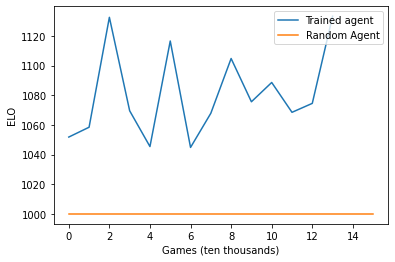

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.lineplot(x = range(14), y = [results["Epoch"+str(i)] for i in range(14)], label = "Trained agent")
ax.set(xlabel = "Games (ten thousands)", ylabel = "ELO")
sns.lineplot(x = range(16), y = [results["Random"] for i in range(16)], label = "Random Agent")
plt.show()